In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist

In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

11490434/11490434 [==============================] - 42s 4us/step


In [5]:
epochs = 10
batch_size = 16
margin = 1

In [6]:
x_train, x_val = x_train[:30000], x_train[30000:]
y_train, y_val = y_train[:30000], y_train[30000:]

In [8]:
def make_pairs(x, y):
    num_classes = max(y) + 1
    digit_indices = [np.where(y == i)[0] for i in range(num_classes)]

    pairs = []
    labels = []

    for idx1 in range(len(x)):
        x1 = x[idx1]
        label1 = y[idx1]
        idx2 = random.choice(digit_indices[label1])
        x2 = x[idx2]

        pairs.append([x1, x2])
        labels.append(1)

        labels2 = random.randint(0, num_classes - 1)
        while labels2 == label1:
            labels2 = random.randint(0, num_classes - 1)

        idx2 = random.choice(digit_indices[labels2])
        x2 = x[idx2]

        pairs.append([x1, x2])
        labels.append(0)

    return np.array(pairs), np.array(labels).astype('float32')

# Define x_train, y_train, x_val, y_val, x_test, y_test before using make_pairs

pairs_train, labels_train = make_pairs(x_train, y_train)
pairs_val, labels_val = make_pairs(x_val, y_val)
pairs_test, labels_test = make_pairs(x_test, y_test)

In [10]:
x_train_1 = pairs_train[:,0]
x_train_2 = pairs_train[:,1]

In [11]:
x_val_1 = pairs_val[:,0]
x_val_2 = pairs_val[:,1]

In [12]:
x_test_1 = pairs_test[:,0]
x_test_2 = pairs_test[:,1]

In [22]:
def visualize(pairs, labels, to_show=6, num_col=3, predictions=None, test=False):
    num_row = to_show // num_col if to_show // num_col != 0 else 1

    to_show = num_row * num_col

    fig, axes = plt.subplots(num_row, num_col, figsize=(5, 5))
    for i in range(to_show):
        if num_row == 1:
            ax = axes[i % num_col]
        else:
            ax = axes[i // num_col, i % num_col]
        
        concatenated_image = tf.concat([pairs[i][0], pairs[i][1]], axis=1)
        ax.imshow(concatenated_image, cmap='gray')
        ax.set_axis_off()
        
        if test:
            ax.set_title("True: {} | Pred: {:.5f}".format(labels[i], predictions[i][0]))
        else:
            ax.set_title("Label: {}".format(labels[i]))
    
    if test:
        plt.tight_layout(rect=(0, 0, 1.9, 1.9), w_pad=0.0)
    else:
        plt.tight_layout(rect=(0, 0, 1.5, 1.5))
    
    plt.show()

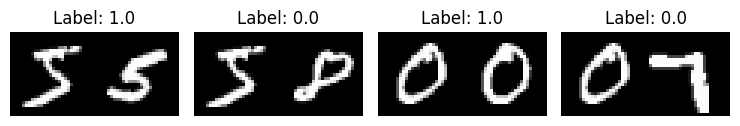

In [23]:
visualize(pairs_train[:-1], labels_train[:-1], to_show=4, num_col=4)

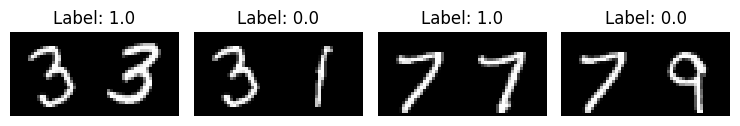

In [24]:
visualize(pairs_val[:-1], labels_val[:-1], to_show=4, num_col=4)

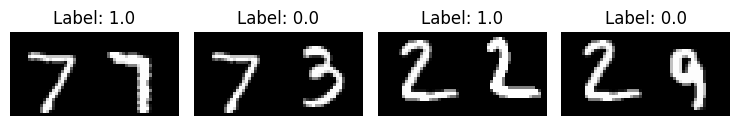

In [25]:
visualize(pairs_test[:-1], labels_test[:-1], to_show=4, num_col=4)

In [26]:
def euclidean_distance(vects):
    x,y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x-y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))

In [27]:
input = layers.Input((28,28,1))
x = tf.keras.layers.BatchNormalization()(input)
x = layers.Conv2D(4, (5,5), activation='tanh')(x)
x = layers.AveragePooling2D(pool_size=(2,2))(x)
x = layers.Conv2D(16, (5,5), activation='tanh')(x)
x = layers.AveragePooling2D(pool_size=(2,2))(x)
x = layers.Flatten()(x)

x = tf.keras.layers.BatchNormalization()(x)
x = layers.Dense(10, activation='tanh')(x)
embedding_network = tf.keras.Model(input, x)

input_1 = layers.Input((28,28,1))
input_2 = layers.Input((28,28,1))

tower_1 = embedding_network(input_1)
tower_2 = embedding_network(input_2)

merge_layer = layers.Lambda(euclidean_distance)([tower_1, tower_2])
normal_layer = tf.keras.layers.BatchNormalization()(merge_layer)
output_layer = layers.Dense(1, activation='sigmoid')(normal_layer)
siamese = tf.keras.Model(inputs=[input_1, input_2], outputs=output_layer)

In [28]:
def loss(margin=1):

    def constrastive_loss(y_true, y_pred):
        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
        return tf.math.reduce_mean((1 - y_true) * square_pred + (y_true) + margin_square)
    return constrastive_loss

In [29]:
siamese.compile(loss=loss(margin=margin), optimizer='RMSprop', metrics=['accuracy'])
siamese.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 model (Functional)          (None, 10)                   5318      ['input_2[0][0]',             
                                                                     'input_3[0][0]']             
                                                                                                  
 lambda (Lambda)             (None, 1)                    0         ['model[0][0]',         

In [30]:
history = siamese.fit([x_train_1,x_train_2], labels_train, validation_data=([x_val_1, x_val_2], labels_val), batch_size=batch_size, epochs=epochs)

Epoch 1/10
3750/3750 [==============================] - 36s 9ms/step - loss: 0.8291 - accuracy: 0.5141 - val_loss: 0.7839 - val_accuracy: 0.6815
Epoch 2/10
3750/3750 [==============================] - 33s 9ms/step - loss: 0.7804 - accuracy: 0.6662 - val_loss: 0.7697 - val_accuracy: 0.7194
Epoch 3/10
3750/3750 [==============================] - 33s 9ms/step - loss: 0.7743 - accuracy: 0.6819 - val_loss: 0.7658 - val_accuracy: 0.7664
Epoch 4/10
3750/3750 [==============================] - 33s 9ms/step - loss: 0.7725 - accuracy: 0.6865 - val_loss: 0.7641 - val_accuracy: 0.7504
Epoch 5/10
3750/3750 [==============================] - 33s 9ms/step - loss: 0.7713 - accuracy: 0.6892 - val_loss: 0.7635 - val_accuracy: 0.7821
Epoch 6/10
3750/3750 [==============================] - 31s 8ms/step - loss: 0.7702 - accuracy: 0.6924 - val_loss: 0.7631 - val_accuracy: 0.7596
Epoch 7/10
3750/3750 [==============================] - 33s 9ms/step - loss: 0.7696 - accuracy: 0.6931 - val_loss: 0.7623 - val_ac

In [31]:
siamese.save('siamese.h5')

E:\Anaconda\envs\Entropy\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


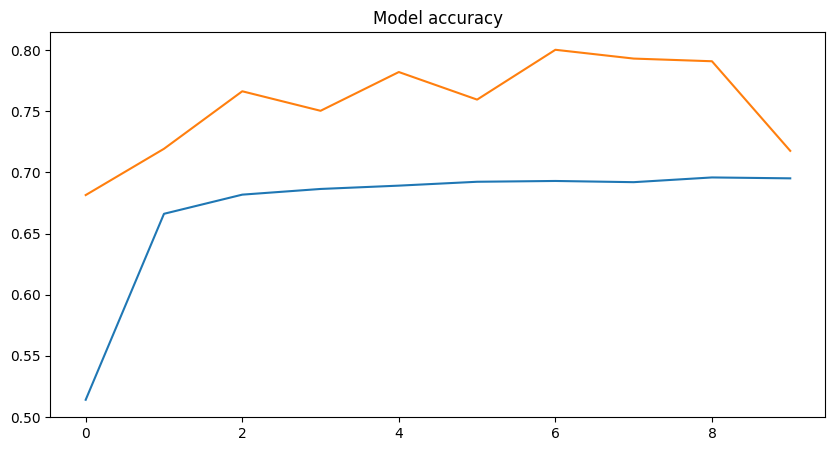

In [36]:
plt.figure(figsize=(10,5))
plt.plot(siamese.history.history['accuracy'], label='accuracy')
plt.plot(siamese.history.history['val_accuracy'], label='val_accuracy')
plt.title('Model accuracy')
plt.show()

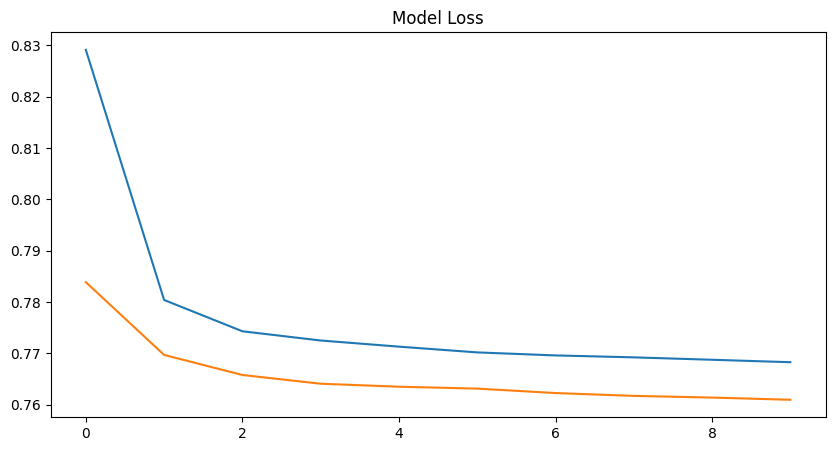

In [37]:
plt.figure(figsize=(10,5))
plt.plot(siamese.history.history['loss'], label='Loss')
plt.plot(siamese.history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.show()

In [38]:
results = siamese.evaluate([x_test_1, x_test_2], labels_test)
print('Test loss, Test accuracy: ', results)

625/625 [==============================] - 3s 5ms/step - loss: 0.7607 - accuracy: 0.7219
Test loss, Test accuracy:  [0.7607080340385437, 0.7219499945640564]


625/625 [==============================] - 3s 4ms/step


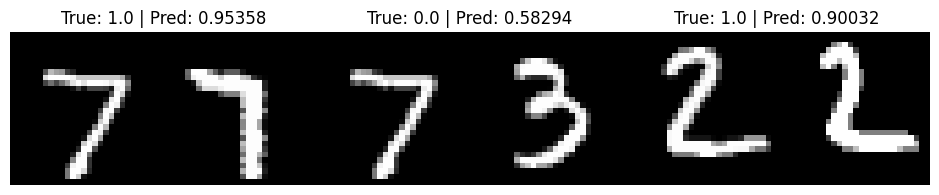

In [39]:
predictions = siamese.predict([x_test_1, x_test_2])
visualize(pairs_test, labels_test, to_show=3, predictions=predictions, test=True)